11th of February 2021

# Predicting Bike Rentals

Many American cities have communal bike sharing stations where we can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

We can download the data from the University of California, [Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

Here are the descriptions for the relevant columns:

- `instant` - record index
- `dteday` - date
- `season` - season (1: winter, 2: spring, 3: summer, 4: fall)
- `yr` - year (0: 2011, 1: 2012)
- `mnth` - month (1 to 12)
- `hr` - hour (0 to 23)
- `holiday` -  weather day is holiday or not (extracted from [Web Link](https://dchr.dc.gov/page/holiday-schedules))
- `weekday` - The day of the week (as a number, 0 to 7)
- `workingday` - if day is neither weekend nor holiday is 1, otherwise is 0.
- `weathersit` - The weather (as a categorical variable)
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- `temp` - The temperature, on a 0-1 scale. Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- `atemp` - The adjusted temperature. Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- `hum` - The humidity, on a 0-1 scale. Normalized humidity. The values are divided to 100 (max)
- `windspeed` - The wind speed, on a 0-1 scale. Normalized wind speed. The values are divided to 67 (max)
- `casual` - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- `registered` - The number of registered riders (people who had already signed up)
- `cnt` - The total number of bike rentals (casual + registered)

In [1]:
# Libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

### 01 Introduction to the dataset

In [2]:
# Read the .csv file:
bike_rentals = pd.read_csv('.../hour.csv', dayfirst=['dteday'], parse_dates=['dteday'])

# Drop the 'instant' column:
bike_rentals = bike_rentals.drop(['instant'], axis=1)

# Display the first 5 rows of the 'bike_rentals' dataframe:
bike_rentals.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
bike_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   dteday      17379 non-null  datetime64[ns]
 1   season      17379 non-null  int64         
 2   yr          17379 non-null  int64         
 3   mnth        17379 non-null  int64         
 4   hr          17379 non-null  int64         
 5   holiday     17379 non-null  int64         
 6   weekday     17379 non-null  int64         
 7   workingday  17379 non-null  int64         
 8   weathersit  17379 non-null  int64         
 9   temp        17379 non-null  float64       
 10  atemp       17379 non-null  float64       
 11  hum         17379 non-null  float64       
 12  windspeed   17379 non-null  float64       
 13  casual      17379 non-null  int64         
 14  registered  17379 non-null  int64         
 15  cnt         17379 non-null  int64         
dtypes: datetime64[ns](1), 

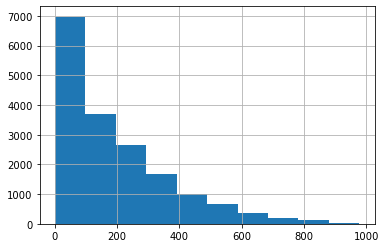

In [4]:
# Histogram of the 'cnt' column to take a look at the distribution
# of total rentals.
bike_rentals['cnt'].hist()

In [5]:
# Calculate correlations to explore how each column is correlated
# with 'cnt' column:
bike_rentals.corr()['cnt']

season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

### 02 Calculating Features

It can often be helpful to calculate features before applying machine learning models. Features can enhance the accuracy of models by introducing new information, or distilling existing information.

For example, the `hr` column in `bike_rentals` contains the hours during which bikes are rented, from `1` to `24`. A machine will treat each hour differently, without understanding that certain hours are related. We can introduce some order into the process by creating a new column with labels for `morning`, `afternoon`, `evening`, and `night`. This will bundle similar times together, enabling the model to make better decisions.



In [6]:
def assign_label(hour):
    """
    This function takes in a numeric value for an hour and returns:
    - 1 if the hour is from 6 to 12,
    - 2 if the hour is from 12 to 18,
    - 3 if the hour is from 18 to 24, and
    - 4 if the hour is from 0 to 6.
    """
    
    if hour >= 6 and hour < 12:
        label = 1
    elif hour >= 12  and hour < 18:
        label = 2
    elif hour >= 18 and hour < 24:
        label = 3
    else:
        label = 4
    
    return label

In [7]:
# Apply the 'assign_label' function to each item in the 'hr' column,
# and assign the new labels to the 'time_label' column:
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)

### 03 Splitting the Data into Training and Test sets

Before we can begin applying machine learning algorithms, we need to split the data into training and test sets. This will enable us to train an algorithm using the training set, and evaluate its accuracy on the testing set. If we train an algorithm on the training data, then evaluate its performance on the same data, we can get an unrealistically low error value, due to overfitting.

In [8]:
# Training set:
# Select 80% of the rows in 'bike_rentals' to be part of the training set
# using the .sample() method:
train = bike_rentals.sample(frac=.8, random_state=1)

In [9]:
# Test set
test = bike_rentals[~bike_rentals.index.isin(train.index)]

### 04 Applying Linear Regression

Now that we have done some exploration and preparation, we are ready to apply linear regression to the data. Linear regression will probably work fairly well on this data, given that some of the columns are correlated with `cnt`.

Generally, Linear Regression works best when predictors are linearly correlated to the target and also independent each other.

We will need to ignore the `casual` and `registered` columns because `cnt` is derived from them. If we are trying to predict the number of people who rent bikes in a given hour (`cnt`), it does not make sense that we already know `casual` or `registered`, because those numbers are added together to get `cnt`.

In [10]:
##################
## Training set ##
##################

# Define the features (predictors):
X_train = train.drop(['dteday', 'casual', 'registered', 'cnt'], axis=1)

# Define the target:
y_train = train['cnt']

##############
## Test set ##
##############

# Define the features (predictors):
X_test = test.drop(['dteday', 'casual', 'registered', 'cnt'], axis=1)

# Define the target:
y_test = test['cnt']

In [11]:
# Fit the Linear Regression model:
reg = LinearRegression().fit(X_train, y_train)

# Make predictions using the test set:
y_pred = reg.predict(X_test)

# Calculate the mean squared error - regression loss:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('MSE: {}, RMSE: {}'.format(round(mse, 2), round(rmse, 2)))

MSE: 17054.96, RMSE: 130.59


The error is very high, which may be due to the fact that the data has a few extremely high rental counts (extreme values) which may generate large error that are penilised more with MSE.

### 05 Applying Decision Trees
Now we are ready to apply the decision tree algorithm. We will be able to compare its error with the error from linear regression, which will enable us to pick the right algorithm for this dataset.

Decision trees tend to predict outcomes much more reliably than linear regression models. Because a decision tree is a fairly complex model, it also tends to overfit, particularly when we do not tweak parameters like maximum depth and minimum number of samples per leaf. Decision trees are also prone to instability -- small changes in the input data can result in a very different output model.

In [12]:
dtree_reg = DecisionTreeRegressor().fit(X_train, y_train)
y_pred_tree = dtree_reg.predict(X_test)
mse_tree = mean_squared_error(y_test, y_pred_tree)
rmse_tree = np.sqrt(mse_tree)
print('MSE: {}, RMSE: {}'.format(round(mse_tree, 2), round(rmse_tree, 2)))

MSE: 3585.69, RMSE: 59.88


By taking the nonlinear predictors into account, the decision tree regressor appears to have much higher accuracy than linear regression.

### 06 Applying Random Forest
We can now apply the random forest algorithm, which improves on the decision tree algorithm. Random forests tend to be much more accurate than simple models like linear regression. Due to the way random forests are constructed, they tend to overfit much less than decision trees. Random forests can still be prone to overfitting, though, so it's important to tune parameters like maximum depth and minimum samples per leaf.

In [13]:
rf_reg = RandomForestRegressor().fit(X_train, y_train)
y_pred_rf = rf_reg.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
print('MSE: {}, RMSE: {}'.format(round(mse_rf, 2), round(rmse_rf, 2)))

MSE: 1987.71, RMSE: 44.58


By removing some of the sources of overfitting, the random forest accuracy is improved over the decision tree accuracy.

In [14]:
errors = pd.DataFrame({'Errors': [rmse, rmse_tree, rmse_rf]},
                      index=['Linear Regression', 'Decision Tree', 'Random Forest'])
errors

,Errors
Linear Regression,130.594638
Decision Tree,59.880628
Random Forest,44.583760


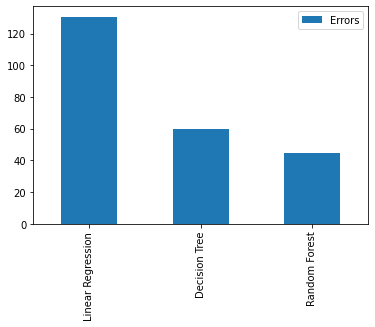

In [15]:
errors.plot(kind='bar')